In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("minhnhtl05/fetal-planes-db-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fetal-planes-db-dataset' dataset.
Path to dataset files: /kaggle/input/fetal-planes-db-dataset


In [3]:
import os

dataset_path = "/kaggle/input/fetal-planes-db-dataset"

print("📂 Dataset Path:", dataset_path)
print("\n🔍 Listing folders and files:\n")

for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/  ({len(files)} files)")
    for d in dirs:
        print(f"{indent}    {d}/")


📂 Dataset Path: /kaggle/input/fetal-planes-db-dataset

🔍 Listing folders and files:

fetal-planes-db-dataset/  (0 files)
    Fetal_Planes_DB/
    Fetal_Planes_DB/  (0 files)
        val/
        test/
        train/
        val/  (0 files)
            Other/
            Fetal brain/
            Fetal thorax/
            Maternal cervix/
            Fetal femur/
            Fetal abdomen/
            Other/  (421 files)
            Fetal brain/  (309 files)
            Fetal thorax/  (171 files)
            Maternal cervix/  (162 files)
            Fetal femur/  (104 files)
            Fetal abdomen/  (71 files)
        test/  (0 files)
            Other/
            Fetal brain/
            Fetal thorax/
            Maternal cervix/
            Fetal femur/
            Fetal abdomen/
            Other/  (1265 files)
            Fetal brain/  (928 files)
            Fetal thorax/  (517 files)
            Maternal cervix/  (489 files)
            Fetal femur/  (312 files)
            Fet

In [4]:
import os
import pandas as pd

base_path = "/kaggle/input/fetal-planes-db-dataset/Fetal_Planes_DB"
splits = ["train", "val", "test"]

def build_dataframe(split_name):
    split_path = os.path.join(base_path, split_name)
    filepaths = []
    labels = []

    # هر کلاس یک فولدر است
    for class_name in sorted(os.listdir(split_path)):
        class_dir = os.path.join(split_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        for fname in os.listdir(class_dir):
            if fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                filepaths.append(os.path.join(class_dir, fname))
                labels.append(class_name)

    df = pd.DataFrame({
        "filepath": filepaths,
        "label": labels
    })
    return df

# ساخت دیتافریم‌ها
train_df = build_dataframe("train")
val_df   = build_dataframe("val")
test_df  = build_dataframe("test")

# چاپ خلاصه برای هر بخش
print("🔹 Train shape:", train_df.shape)
print(train_df.head(), "\n")
print(train_df['label'].value_counts(), "\n")


🔹 Train shape: (7437, 2)
                                            filepath          label
0  /kaggle/input/fetal-planes-db-dataset/Fetal_Pl...  Fetal abdomen
1  /kaggle/input/fetal-planes-db-dataset/Fetal_Pl...  Fetal abdomen
2  /kaggle/input/fetal-planes-db-dataset/Fetal_Pl...  Fetal abdomen
3  /kaggle/input/fetal-planes-db-dataset/Fetal_Pl...  Fetal abdomen
4  /kaggle/input/fetal-planes-db-dataset/Fetal_Pl...  Fetal abdomen 

label
Other              2527
Fetal brain        1855
Fetal thorax       1030
Maternal cervix     975
Fetal femur         624
Fetal abdomen       426
Name: count, dtype: int64 



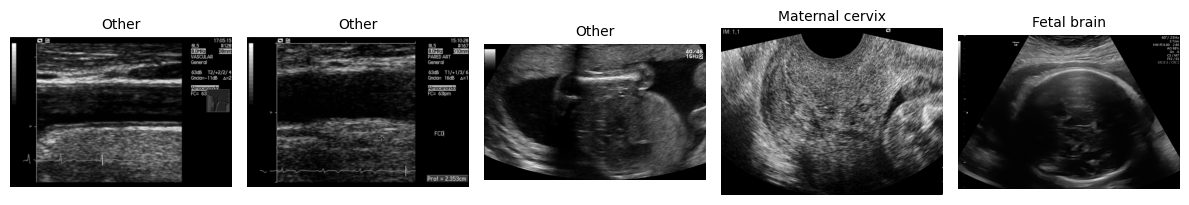

In [5]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# از دیتافریم train_df که ساختیم استفاده می‌کنیم
samples = train_df.sample(5).reset_index(drop=True)

plt.figure(figsize=(12, 6))

for i in range(5):
    img_path = samples["filepath"][i]
    label = samples["label"][i]

    img = Image.open(img_path)

    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap="gray")   # چون سونوگرافی معمولاً grayscale است
    plt.title(label, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# ---------------------------
# 0) Device (GPU or CPU)
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------
# 1) Paths
# ---------------------------
base_dir = "/kaggle/input/fetal-planes-db-dataset/Fetal_Planes_DB"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

Device: cuda


In [7]:

# ---------------------------
# 2) Transforms
# ---------------------------
# ImageNet normalization (برای EfficientNetV2)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # سونوگرافی → ۳ کاناله
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# ---------------------------
# 3) Datasets & Dataloaders
# ---------------------------
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir,   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=val_test_transform)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", train_dataset.classes)
print("Num train:", len(train_dataset))
print("Num val:", len(val_dataset))
print("Num test:", len(test_dataset))

# ---------------------------
# 4) Model: EfficientNetV2-S (pretrained)
# ---------------------------
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = efficientnet_v2_s(weights=weights)

# تعویض لایه‌ی آخر برای ۶ کلاس
num_features = model.classifier[1].in_features
model.classifier[-1] = nn.Linear(num_features, 6)

model = model.to(device)

# ---------------------------
# 5) Loss & Optimizer
# ---------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# ---------------------------
# 6) Train & Eval Functions
# ---------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# ---------------------------
# 7) Training Loop
# ---------------------------
num_epochs = 15

best_val_acc = 0.0
best_model_path = "best_efficientnet_v2_s_fetal_planes.pth"

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc     = evaluate(model, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

    # ذخیره بهترین مدل براساس val accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  ✅ Best model updated! (Val Acc: {best_val_acc:.2f}%)")

print("\nTraining finished.")
print("Best Val Accuracy:", best_val_acc)

# ---------------------------
# 8) Load Best Model & Test
# ---------------------------
model.load_state_dict(torch.load(best_model_path, map_location=device))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\n💡 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

Classes: ['Fetal abdomen', 'Fetal brain', 'Fetal femur', 'Fetal thorax', 'Maternal cervix', 'Other']
Num train: 7437
Num val: 1238
Num test: 3725
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 209MB/s]


Epoch [1/15]
  Train Loss: 0.4261 | Train Acc: 86.82%
  Val   Loss: 0.1844 | Val   Acc: 94.10%
  ✅ Best model updated! (Val Acc: 94.10%)
Epoch [2/15]
  Train Loss: 0.1498 | Train Acc: 95.19%
  Val   Loss: 0.1960 | Val   Acc: 93.21%
Epoch [3/15]
  Train Loss: 0.1040 | Train Acc: 96.61%
  Val   Loss: 0.1895 | Val   Acc: 93.54%
Epoch [4/15]
  Train Loss: 0.0801 | Train Acc: 97.22%
  Val   Loss: 0.1619 | Val   Acc: 94.18%
  ✅ Best model updated! (Val Acc: 94.18%)
Epoch [5/15]
  Train Loss: 0.0591 | Train Acc: 98.16%
  Val   Loss: 0.1784 | Val   Acc: 94.51%
  ✅ Best model updated! (Val Acc: 94.51%)
Epoch [6/15]
  Train Loss: 0.0532 | Train Acc: 98.29%
  Val   Loss: 0.2110 | Val   Acc: 93.78%
Epoch [7/15]
  Train Loss: 0.0454 | Train Acc: 98.56%
  Val   Loss: 0.2366 | Val   Acc: 94.10%
Epoch [8/15]
  Train Loss: 0.0332 | Train Acc: 98.92%
  Val   Loss: 0.1823 | Val   Acc: 95.23%
  ✅ Best model updated! (Val Acc: 95.23%)
Epoch [9/15]
  Train Loss: 0.0264 | Train Acc: 99.13%
  Val   Loss: 0.22